# Human BoneMarrow

Human bonemarrow dataset used in this tutorial is acquired from [Setty et al. (2019)](https://www.nature.com/articles/s41587-019-0068-4). Bone marrow plays an crucial role in new blood cell production and contributes the generation of certain immune cells. 

This dataset can be used to detect essential parts of hematopoietic differentiation and possibly the key transcription factors that contributes to the fate choice of cells within lineage. 

As annotated in original paper, this dataset has three terminal states starting from HSCs, 1) erythroids, 2) monocytes and dendritic cells (DC) and 3) common lymphoid progenitor cells (CLP).

In [1]:
import scvelo as scv
scv.settings.verbosity = 0
import unitvelo as utv

(Running UniTVelo 0.1.0)
2022-03-31 16:41:28


In [2]:
adata = scv.datasets.bonemarrow()
adata

AnnData object with n_obs × n_vars = 5780 × 14319
    obs: 'clusters', 'palantir_pseudotime'
    uns: 'clusters_colors'
    obsm: 'X_tsne'
    layers: 'spliced', 'unspliced'

In [3]:
# dataset = '../data/BoneHuman/adata.h5ad'
dataset = './data/BoneMarrow/human_cd34_bone_marrow.h5ad'
label = 'clusters'
exp_metrics = {}

Parameter `cluster_edges` is for algorithm evaluation purpose given expert annotated ground truth. It contains a list of tuples in which stores the source cluster and target cluster of cells.

In [4]:
cluster_edges = [
    ("HSC_1", "Ery_1"), 
    ("HSC_1", "HSC_2"), 
    ("Ery_1", "Ery_2")]

## scVelo stochastic

  0%|          | 0.00/162M [00:00<?, ?B/s]

  0%|          | 0/5780 [00:00<?, ?cells/s]

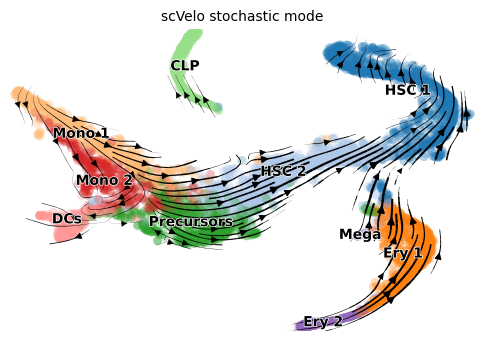

In [4]:
title = 'scVelo stochastic mode'
adata = scv.datasets.bonemarrow()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata, mode='stochastic')

scv.tl.velocity_graph(adata)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [7]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity', 'X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8610344021621074, ('HSC_1', 'HSC_2'): -0.6894453298758585, ('Ery_1', 'Ery_2'): -0.9029748019500254}
Total Mean: -0.8178181779959971
# In-cluster Coherence
{'CLP': 0.9074381, 'DCs': 0.9658171, 'Ery_1': 0.9692909, 'Ery_2': 0.9902824, 'HSC_1': 0.85452265, 'HSC_2': 0.9181577, 'Mega': 0.9639771, 'Mono_1': 0.9242185, 'Mono_2': 0.93995243, 'Precursors': 0.9324791}
Total Mean: 0.9366135597229004


## scVelo dynamic

  0%|          | 0/558 [00:00<?, ?gene/s]

  0%|          | 0/5780 [00:00<?, ?cells/s]

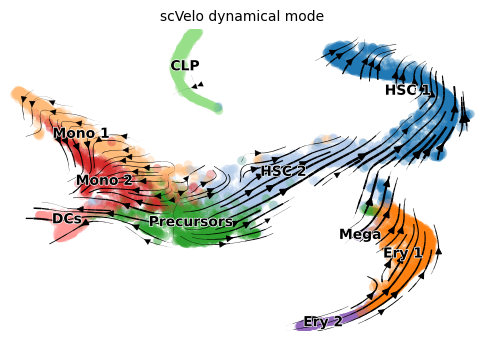

In [8]:
title = 'scVelo dynamical mode'
adata = scv.datasets.bonemarrow()
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, n_jobs=20)
scv.tl.velocity(adata, mode='dynamical')

scv.tl.velocity_graph(adata)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=label, dpi=100, title=title)

In [9]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity', 'X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): -0.8767161904580902, ('HSC_1', 'HSC_2'): -0.7406097536917645, ('Ery_1', 'Ery_2'): -0.9011676612630122}
Total Mean: -0.8394978684709556
# In-cluster Coherence
{'CLP': 0.8011706364672638, 'DCs': 0.8831685428853896, 'Ery_1': 0.968510822837128, 'Ery_2': 0.9811672009214301, 'HSC_1': 0.93928965140427, 'HSC_2': 0.9335215285774672, 'Mega': 0.9773211685600964, 'Mono_1': 0.9071636866829598, 'Mono_2': 0.9244984234425947, 'Precursors': 0.8666819017376352}
Total Mean: 0.9182493563516235


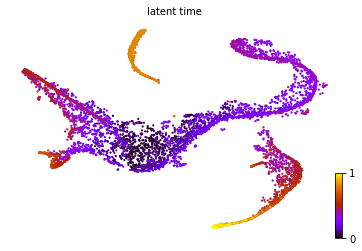

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

## UniTVelo

UniTVelo requires a configuration file as input. You may sub-class it from base config file `config.py` and override the parameters you need to change (demonstrated below). For the details and comments of each parameter, please refer to `config.py`.

In [5]:
velo_config = utv.config.Configuration()

We highlight gene selection is a highly crucial step for the calculation of RNA veocity and construction of velocity graph. Though different methods have been adopted for stochastic and dynamical mode respectively, they are based on regression without offsets. Due to the complexity of this dataset, we use regression with offsets to select velocity genes (`velo_config.OFFSET_GENES = True`), hoping more informative genes can be included. `velo_config.R2_ADJUST` will be overridden under this setting.

In [6]:
velo_config.OFFSET_GENES = True
velo_config.R2_ADJUST = False
velo_config.IROOT = 'HSC_1'
velo_config.FIT_OPTION = '1'

-------> Model Configuration Settings <-------

 GPU: 2	FIG_DIR: ./figures/	BASE_FUNCTION: Gaussian	
 GENERAL: Curve	BASIS: None	N_TOP_GENES: 2000	
 OFFSET_GENES: True	FILTER_CELLS: False	EXAMINE_GENE: False	
 RESCALE_TIME: False	RESCALE_DATA: True	R2_ADJUST: False	
 IROOT: HSC_1	NUM_REPEAT: 1	FIT_OPTION: 1	
 DENSITY: SVD	REORDER_CELL: Soft_Reorder	AGGREGATE_T: True	
 ASSIGN_POS_U: False	WIN_SIZE: 50	LEARNING_RATE: 0.01	
 MAX_ITER: 10000	USE_RAW: False	RAW_GENES: False	



  0%|          | 0/2000 [00:00<?, ?it/s]

---> # of velocity genes used 1382
---> # of velocity genes used 1203
---> # of velocity genes used 1201
---> Use Diffusion Pseudotime as initial.


  0%|          | 0/10000 [00:00<?, ?it/s]

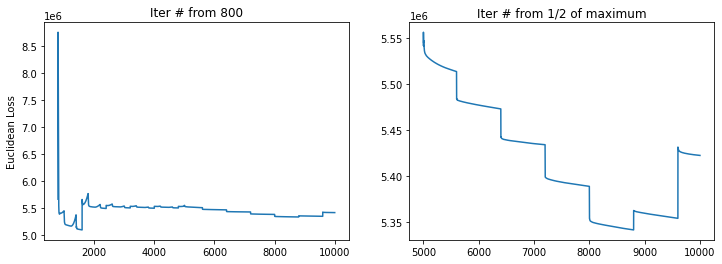

  0%|          | 0/5780 [00:00<?, ?cells/s]

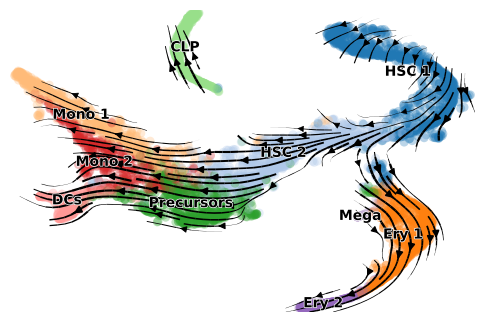

In [7]:
adata = utv.run_model('./data/BoneMarrow/human_cd34_bone_marrow.h5ad', label, config_file=velo_config)
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
scv.pl.velocity_embedding_stream(adata, color=adata.uns['label'], dpi=100, title='')

Beside visual inspections, quantitative metrics also returns a positive transition directionality (Source cluster A, Target cluster B).

In [7]:
scv.pp.neighbors(adata)
adata_velo = adata[:, adata.var.loc[adata.var['velocity_genes'] == True].index]
exp_metrics["model_dyn"] = utv.evaluate(adata_velo, cluster_edges, label, 'velocity', 'X_tsne')

# Cross-Boundary Direction Correctness (A->B)
{('HSC_1', 'Ery_1'): 0.8677359570085336, ('HSC_1', 'HSC_2'): 0.7155699346392855, ('Ery_1', 'Ery_2'): 0.8316256205110811}
Total Mean: 0.8049771707196335
# In-cluster Coherence
{'CLP': 0.9722802580557224, 'DCs': 0.9804014042400353, 'Ery_1': 0.9810560277189699, 'Ery_2': 0.9851508901230266, 'HSC_1': 0.9738339141922948, 'HSC_2': 0.9756208566544446, 'Mega': 0.9861380266382976, 'Mono_1': 0.9728722765824412, 'Mono_2': 0.975874238188986, 'Precursors': 0.9715477279380238}
Total Mean: 0.9774775620332242


Estimated velocity along with transcriptional dynamics can be used to infer internal time of each cell, which is in accordance with [Setty et al. (2019)](https://www.nature.com/articles/s41587-019-0068-4), though minor discrepancies can be observed in CLP lineage. We presume this might related to phase portraits of certain genes has high and discret expressions in CLP lineage.

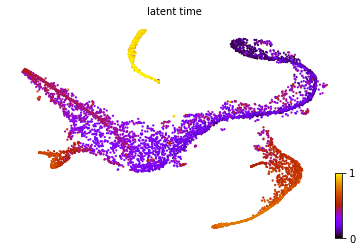

In [8]:
scv.tl.latent_time(adata, min_likelihood=None)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=20)

## Gene-level Analysis

UniTVelo automatically saves updated adata and fitted results under `tempdata` folder of same directory.

In [9]:
adata = scv.read('./data/BoneMarrow/tempdata/temp.h5ad')

In [10]:
subvar = adata.var.loc[adata.var['velocity_genes'] == True]
sub = adata[:, subvar.index]

Peak time is used to roughly classify genes into three distinct catogries, 
- Regression gene of which it transcription profile decreases
- Induction gene with the opposite behavior
- Transient gene with both induced and inhibited traits combined

Since dataset is complex and the phase portraits of quite a few genes we observed does not follow the classic almond shape (termed dynamical genes by scVelo) or monotonically changes (as shown in [Mouse Erythroid](./Figure2_ErythroidMouse.ipynb) and [Intestianl Organoid](./Figure4_IntestinalOrganoid.ipynb)), please proceed with caution when interpreting results of which peak time is around 0.5.

Text(0.5, 1.0, 'Peak Time')

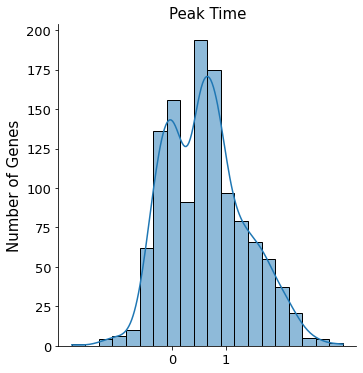

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(sub.var['fit_t0'].values, kde=True, bins=20)
plt.xticks([0, 1], fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel('Number of Genes', fontsize=15)
plt.title('Peak Time', fontsize=15)

Here shows an example of repression gene, `CD44`. Generally the spliced counts follow a decreased manner (from upper right to lower left of the black pahse portrait), though an elevated expression can be observed in unspliced counts.

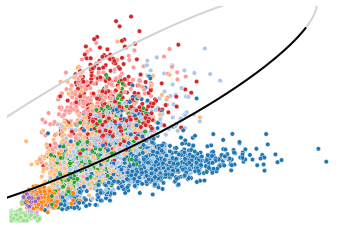

In [13]:
utv.pl.plot_range('CD44', adata, velo_config, 
    show_legend=False, show_ax=False)

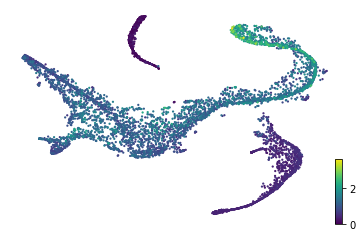

In [14]:
gene_name = 'CD44'
adata.obs['temp'] = adata[:, gene_name].layers['Ms']
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, title='')

To illustrate the high but discret expressions in CLP lineage mentioned above, we use `LAPTM5` as an example, which is also a poorly fitted gene. 

The scatter plor of un/spliced counts shows the transcription acticity does not change much (probably decreased a little) in HSCs, erythroids and monocytes. However, a transcription burst can be observed in CLP lineage. This anomaly easily leads to erroneous or over-fitting of the phase portraits.

Though the general result can be refined with UniTVelo under unified-time setting. Fitting each gene with correct phase portrati individually still remains challenging.

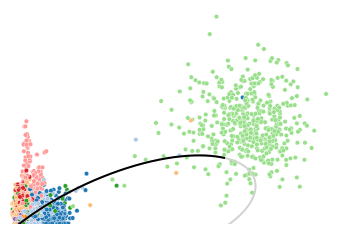

In [20]:
utv.pl.plot_range('LAPTM5', adata, velo_config, 
    show_legend=False, show_ax=False)

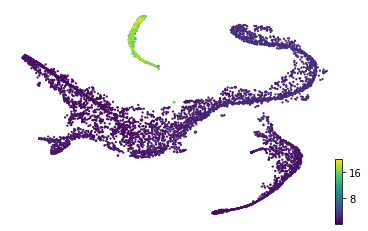

In [21]:
gene_name = 'LAPTM5'
adata.obs['temp'] = adata[:, gene_name].layers['Ms']
scv.pl.scatter(adata, color='temp', color_map='viridis', size=20, title='')

## Heatmap
Heatmaps shows the expression profile (rows) againese cell ordering (columns, inferred cell time). Brighter color represents higher expression.

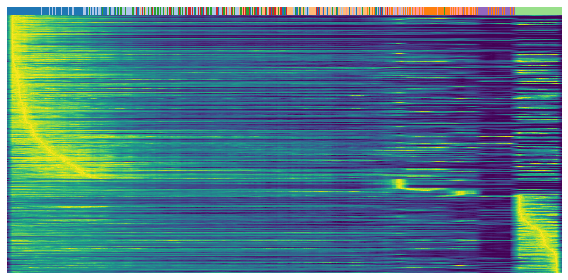

In [16]:
adata.uns['clusters_colors'] = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5']
gene = sub.var.loc[sub.var['fit_t0'] < 0.05].index # repression
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color=label, n_convolve=100)

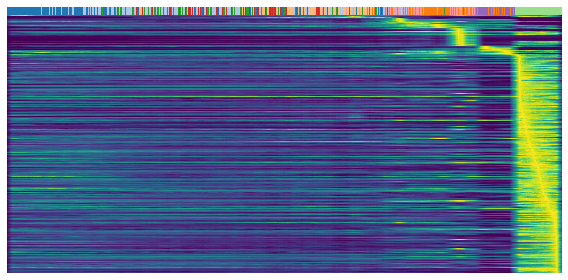

In [17]:
gene = sub.var.loc[sub.var['fit_t0'] > 0.95].index # induction
scv.pl.heatmap(
    adata, var_names=gene, sortby='latent_time', yticklabels=False,
    col_color=label, n_convolve=100)